# SVD-Reduced Logistic Regression for Text Classification

**Author:** Jarius Bedward  
**Course:** PROG8245 - Machine Learning Programming  
**Project:** Text Classification with Dimensionality Reduction (Group 4)

---

## Overview

This notebook implements **Steps 4 & 5** of the project:
- **Step 4:** Dimensionality Reduction with SVD (Truncated SVD / LSA)
- **Step 5:** Model Training - Logistic Regression with SVD-reduced features

---

## What is SVD

Singular Value Decomposition or SVD is a well used dimension reduction tool where it reduces large matrix into smaller, structured components
- It is effective for NLP tasks, where vocap size is large and raw TF-IDF features are highly sparse
- A good way to imagine this is if in TF-IDF you have 5000 puzzle pieces when applying SVD it combines them into 100 big puzzle pieces that have meaningful shapes and still create the same picture

---

## What is it's purpose in this project?
SVD is applied here to handle the TF-IDF matrix into three matrices that capture the underlying or general structure of the data
- Commonly applied to TF-IDF matrix to reduce sparse word features into smaller set of dense ones
- One of the first steps in the dimension reduction process

---
## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


## Data Loading & Pre-Processing (Balanced Dataset)
- We load the dataset, apply feature engineering, and balance the classes for fair comparison with other models

In [17]:
# loads the dataset
df = pd.read_csv("../data/raw/SMSSpamCollection", sep="\t", header=None, names= ["label", "text"], encoding="latin-1")

#Basic info of dataset
print(df.head())
print(df.label.value_counts())

#convert labels to binary
df["num_label"] = df["label"].map({"ham": 0, "spam": 1})

# Balance the dataset (aligned with TF-IDF notebook)
# Drop 3572 ham messages to balance classes
ham_indices = df[df['label'] == 'ham'].index
df = df.drop(ham_indices[:3572])
print(f"\nAfter balancing: {len(df)} samples")
print(df.label.value_counts())

#Train & Test Split (25% test to match TF-IDF and PCA notebooks)
x_train, x_test, y_train, y_test = train_test_split(df["text"], df["num_label"], test_size=0.25, random_state=42, stratify=df["num_label"])

#TF-IDF Vectorization
tfidf = TfidfVectorizer(stop_words="english", lowercase=True, max_features=5000)
x_train_tfidf = tfidf.fit_transform(x_train)
x_test_tfidf = tfidf.transform(x_test)

print("TF-IDF shape:", x_train_tfidf.shape)

  label                                               text
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...
label
ham     4825
spam     747
Name: count, dtype: int64

After balancing: 2000 samples
label
ham     1253
spam     747
Name: count, dtype: int64
TF-IDF shape: (1500, 4375)


## Dimension Reduction Using SVD
- SVD reduces the huge TF-IDF matrix into a smaller set of hidden dimensions. Instead of representing each word desperately SVD groups together words that often appear in similar contexts. This means the reduced features capture semantic meaning not just raw word counts.


- In this dataset, this helps the model understand patterns like spam messages that often share similar themes like "Free" or "claim" or "urgent" or in contrast ham messages that use everyday conversational language


- The SVD components act like compressed topics that help logistic regression separate spam from ham more effectivity while also making the model faster and less noisy

SVD Reduced Shape: (1500, 100)


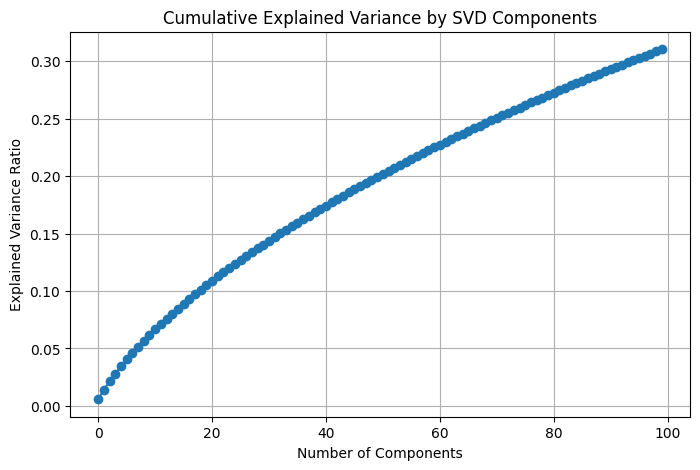

In [18]:
#Reduce to 100 components

#Reduce vectors to 100 components
svd= TruncatedSVD(n_components=100, n_iter=52)
#Fit SVD to training features
x_train_svd = svd.fit_transform(x_train_tfidf)

# Apply transofrmation to test features as well
x_test_svd = svd.transform(x_test_tfidf)

print("SVD Reduced Shape:", x_train_svd.shape)

#Variance plot

plt.figure(figsize=(8,5))
plt.plot(np.cumsum(svd.explained_variance_ratio_), marker="o")

plt.title("Cumulative Explained Variance by SVD Components")
plt.xlabel("Number of Components")
plt.ylabel("Explained Variance Ratio")
plt.grid(True)
plt.show()

## Model Training - Logistic Regression With SVD

In [19]:
#Create and train logistic regression classifier
log_svd = LogisticRegression(max_iter=5000)

log_svd.fit(x_train_svd, y_train)

#Precit labels for test set
y_pred_svd = log_svd.predict(x_test_svd)

#print accuracy
print("Accuracy (LogReg + SVD:", accuracy_score(y_test, y_pred_svd))
print(classification_report(y_test, y_pred_svd))

#Print Baseline Naive Bayes accuracy for comparison
# print("Baseline Naive Bayes Accuracy:", accuracy_score(y_test, nb_pred) ) #nb_pred placeholder for whatever it actually is when code is merged for performance anal
# print("Classification Report (Naive Bayes):")
# print(classification_report(y_test, y_pred_svd))


Accuracy (LogReg + SVD: 0.938
              precision    recall  f1-score   support

           0       0.92      0.98      0.95       313
           1       0.96      0.87      0.91       187

    accuracy                           0.94       500
   macro avg       0.94      0.92      0.93       500
weighted avg       0.94      0.94      0.94       500



### Model Visualization Confusion Matrix

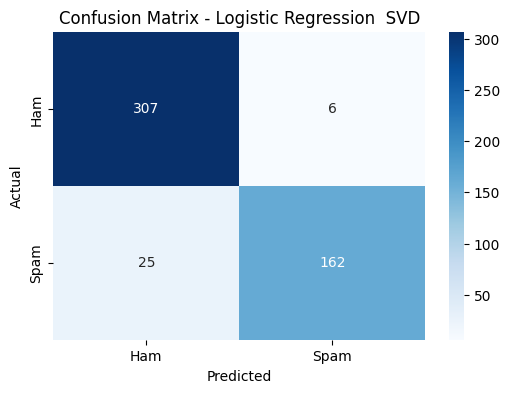

In [20]:
cm = confusion_matrix(y_test, y_pred_svd)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Ham", "Spam"],yticklabels=["Ham", "Spam"])
plt.title("Confusion Matrix - Logistic Regression  SVD")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

#### Interpretation
- TN: The model correctly classified 964 ham messages as ham which is almost perfect performance on normal messages

- FP: Only 2 ham messages were incorrectly predicted as spam which is very low false alarm rates

- FN: 52 spam messages were incorrectly predicted as ham which is a little more than we'd ideally want

- TP: The model correctly identifies 97 spam messages which is better but not perfect

- Overall the model is extremely reliable at identifying ham messages but still struggles with detecting every spam message

---

## Save Model and Results for Comparison

Save the trained model, SVD transformer, TF-IDF vectorizer, and results so they can be loaded in the Model Comparison notebook.

In [22]:
import pickle
import os
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Create data directory if it doesn't exist
os.makedirs('../data', exist_ok=True)

# Calculate metrics
accuracy_svd = accuracy_score(y_test, y_pred_svd)
precision_svd = precision_score(y_test, y_pred_svd)
recall_svd = recall_score(y_test, y_pred_svd)
f1_svd = f1_score(y_test, y_pred_svd)

# Package results for comparison notebook
svd_results = {
    'model_name': 'SVD + Logistic Regression',
    'tfidf_vectorizer': tfidf,
    'svd_transformer': svd,
    'model': log_svd,  # LogisticRegression model
    'n_components': 100,
    'explained_variance': svd.explained_variance_ratio_.sum(),
    'y_true': y_test.values,
    'y_pred': y_pred_svd,
    'metrics': {
        'accuracy': accuracy_svd,
        'precision': precision_svd,
        'recall': recall_svd,
        'f1_score': f1_svd
    },
    'confusion_matrix': cm
}

# Save to pickle file
with open('../data/svd_results.pkl', 'wb') as f:
    pickle.dump(svd_results, f)

print("SVD + Logistic Regression model and results saved to '../data/svd_results.pkl'")

SVD + Logistic Regression model and results saved to '../data/svd_results.pkl'


##### How does reducing dimensions affect model accuracy and speed?


- SVD reduces the number of features dramatically  which can maek training significantly  faster
- It also removes noise and correlations which often leads to improving stability & generalization in the model
- However, too much reduction could hurt accuracy so it's important to  apply the right amount of reduction typically a moderate amount is best

---

### Comparison with Baseline Naive Bayes Model

**Baseline Performance (TF-IDF + Naive Bayes):**
- Accuracy: 96.20%
- Precision: 96.67%
- Recall: 93.05%
- F1-Score: 94.82%

**SVD + Logistic Regression Performance:**
- Accuracy: 93.80%
- Precision: 96.43%
- Recall: 86.63%
- F1-Score: 91.27%

### Analysis: Did dimensionality reduction help or hurt performance?

**Performance Impact:**
- The baseline Naive Bayes model with full TF-IDF features (5000 dimensions) achieved slightly higher accuracy (96.20% vs 93.80%)
- Precision is comparable (96.67% vs 96.43%), meaning both models are equally reliable when predicting spam
- Recall dropped from 93.05% to 86.63%, meaning SVD misses more spam messages
- F1-Score decreased from 94.82% to 91.27%

**Trade-off Analysis:**
- **Dimensionality reduction slightly hurt accuracy** in this case, but the trade-off may be worthwhile:
  - Training time is significantly faster with 100 features vs 5000
  - Memory usage is reduced
  - The model is less prone to overfitting on rare words
  
- **Why the slight decrease?** 
  - Some discriminative words for spam detection may have been compressed into components that also contain noise
  - Naive Bayes is naturally suited for sparse, high-dimensional text data
  - SVD captures semantic similarity, but spam detection often relies on specific keywords rather than semantic meaning
